In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler 

import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv('C:/Users/Chou/CODE/ml1/dataset_lstm.csv',  index_col=0)
df = df.rename(columns={'Close/Last':'Close'})
df = df.reset_index()
df = df[(df['Date'] >= "2012-04-15") & (df['Date'] <= "2024-04-18")].reset_index(drop=True)

In [12]:
print(df.shape)

(2516, 6)


In [13]:
df.head()

,Date,Close,Volume,Open,High,Low
0,2014-04-17,18.7479,283914286,18.5714,18.8486,18.5429
1,2014-04-21,18.9704,182185847,18.7622,19.0050,18.7129
2,2014-04-22,18.9893,202430847,18.8682,18.9938,18.8036
3,2014-04-23,18.7411,373894210,18.8950,18.9689,18.7304
4,2014-04-24,20.2775,758353097,20.2932,20.3572,20.0261


In [14]:
df.tail(6)

,Date,Close,Volume,Open,High,Low
2510,2024-04-09,169.67,42451210,168.70,170.08,168.35
2511,2024-04-10,167.78,49709340,168.80,169.09,167.11
2512,2024-04-11,175.04,91070280,168.34,175.46,168.16
2513,2024-04-12,176.55,101670900,174.26,178.36,174.21
2514,2024-04-15,172.69,73531770,175.36,176.63,172.50
2515,2024-04-16,169.38,73711240,171.75,173.76,168.27


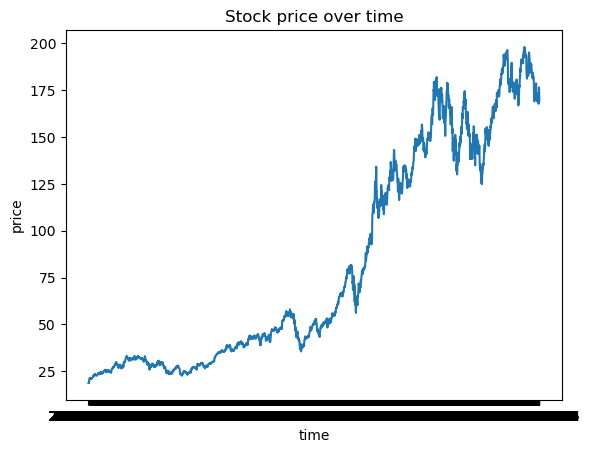

In [15]:
plt.plot(df["Date"], df["Close"])
plt.title("Stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

In [16]:
# scaling the closing price
# MinMaxScaler => y = (y - min(y))/(min(y) - max(y))
scaler = MinMaxScaler(feature_range=(0,1))
df['scaled_values'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))

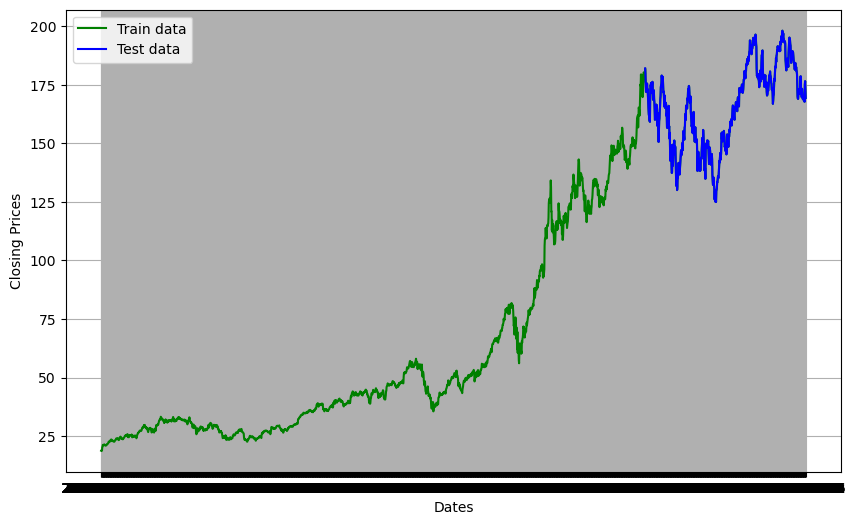

In [17]:
# split data into training and testing set
train_data = df[df['Date'] < '2022-01-01']
test_data = df[df['Date'] >= '2022-01-01']

# plotting the data
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df['Date'], df['Close'], 'green', label='Train data')
plt.plot(test_data['Date'], test_data['Close'], 'blue', label='Test data')
plt.legend()

In [18]:
x_train = []
y_train = []

for i in range(60, len(train_data['scaled_values'])):
    x_train.append(train_data['scaled_values'][i-60:i])
    y_train.append(train_data['scaled_values'][i])
    
x_train, y_train = np.array(x_train), np.array(y_train)

# converting it back to 3D array as required by LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [19]:
x_test = []
y_test = test_data['scaled_values']

for i in range(60, len(test_data)):
    x_test.append(test_data['scaled_values'][i-60:i])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [20]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [21]:
# define model architecture

# Initialize model
model = Sequential()

# LSTM layer 1
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.25))

# LSTM layer 2
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

# LSTM layer 3
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

# LSTM layer 4
model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# final layer
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [22]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [23]:
model.fit(x_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
59/59 [==============================] - 10s 65ms/step - loss: 0.0073
Epoch 2/10
59/59 [==============================] - 4s 64ms/step - loss: 0.0022
Epoch 3/10
59/59 [==============================] - 4s 65ms/step - loss: 0.0019
Epoch 4/10
59/59 [==============================] - 4s 63ms/step - loss: 0.0018
Epoch 5/10
59/59 [==============================] - 4s 63ms/step - loss: 0.0018
Epoch 6/10
59/59 [==============================] - 4s 63ms/step - loss: 0.0019
Epoch 7/10
59/59 [==============================] - 4s 62ms/step - loss: 0.0020
Epoch 8/10
59/59 [==============================] - 4s 64ms/step - loss: 0.0017
Epoch 9/10
59/59 [==============================] - 4s 63ms/step - loss: 0.0015
Epoch 10/10
59/59 [==============================] - 4s 63ms/step - loss: 0.0013


In [24]:
# predict on test data
predicted_stock_price = model.predict(x_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

17/17 [==============================] - 2s 30ms/step


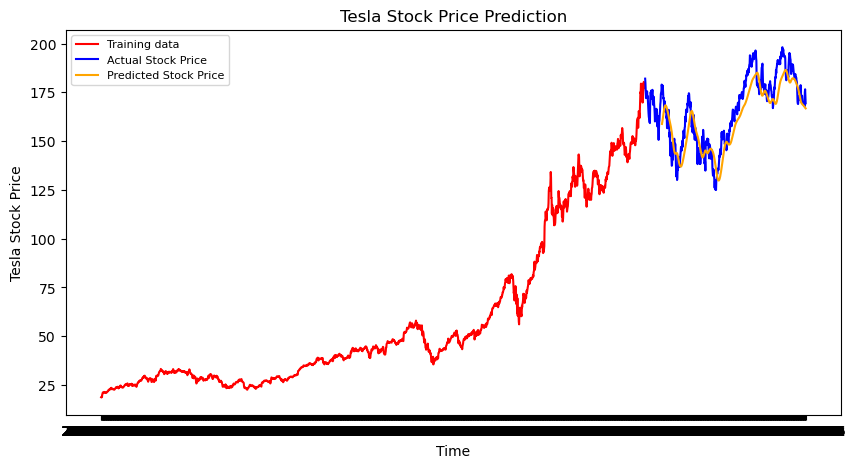

In [27]:
# plot all the series together
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data['Date'], train_data['Close'], color = 'red', label='Training data')
plt.plot(test_data['Date'], test_data['Close'], color = 'blue', label='Actual Stock Price')
plt.plot(test_data[60:]['Date'], predicted_stock_price, color = 'orange',label='Predicted Stock Price')

plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [28]:
from sklearn.metrics import mean_absolute_error
import math

y_true = test_data[60:]['Close'].values
y_pred = predicted_stock_price

# report performance
mse = mean_squared_error(y_true, y_pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(y_true, y_pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
print('MAPE: '+str(mape))

MSE: 75.91287722077112
MAE: 7.351308731494711
RMSE: 8.712799620143409
MAPE: 0.1216771588749799
